In [23]:
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.notebook import tqdm
import shap
from PIL import Image
from ray import tune, train
from ray.air import session, Checkpoint
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.hyperopt import HyperOptSearch
from ray.train.torch import TorchTrainer, TorchCheckpoint
from ray.air.config import ScalingConfig
import ray
import os

In [3]:
class ResNet(nn.Module):
    def __init__(self, c_in, c_out=-1, subsample=False):
        super().__init__()

        if not subsample:
            c_out = c_in
        
        self.net = nn.Sequential(
            nn.BatchNorm2d(c_in),
            nn.SiLU(),
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, stride=1 if not subsample else 2, bias=False),
            nn.BatchNorm2d(c_out),
            nn.SiLU(),
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1, bias=False),
        )

        self.downsample = nn.Sequential(
            nn.BatchNorm2d(c_in),
            nn.SiLU(),
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, stride=2, bias=False)
        ) if subsample else None

    def forward(self, x):
        z = self.net(x)
        if self.downsample is not None:
            x = self.downsample(x)
        out = x + z
        return out


class OLoc(nn.Module):
    def __init__(self, num_blocks=2, num_in_blocks=3, num_outputs=4):
        super().__init__()

        c_hidden = [16 * i for i in range(1, num_blocks + 1)]
        
        self.input_net = nn.Conv2d(3, c_hidden[0], kernel_size=3, padding=1, bias=False)

        blocks = []
        
        for idx in range(num_blocks):
            for bc in range(num_in_blocks):
                subsample = bc == 0 and idx > 0
                blocks.append(ResNet(c_hidden[idx if not subsample else (idx - 1)],
                                     c_hidden[idx],
                                     subsample=subsample))
            blocks.append(nn.Dropout(0.2))
        self.net = nn.Sequential(*blocks)

        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(c_hidden[-1], num_outputs)
        )

    def forward(self, x):
        x = self.input_net(x)
        x = self.net(x)
        x = self.output_net(x)
        return x

In [4]:
class ImageDataset(data.Dataset):
    def __init__(self, imgs, labels, transform=None):
        self.imgs = imgs
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        label = self.labels[idx]
        if self.transform is not None:
            img = self.transform(self.imgs[idx])
        else:
            img = self.imgs[idx]
        return img, label

In [20]:
def get_data():
    imgs_list = []
    for i in range(1,301):
        imgs_list.append(transforms.functional.pil_to_tensor(Image.open(f'images/{i}.png')) / 255)
    
    imgs_list = torch.stack(imgs_list)
    
    label_list = []
    with open('square_pos.csv', 'r', encoding='utf-8-sig') as file:
        label_list = [[int(i) for i in line.split(',')] for line in file]
    
    label_list = torch.tensor(label_list).to(torch.float)

    return imgs_list, label_list

def create_datasets(imgs, labels):
    train_transforms = transforms.Compose([
        transforms.ColorJitter(brightness=.5, hue=.2, saturation=0.2, contrast=0.2),
        transforms.GaussianBlur(kernel_size=(3,3), sigma=(0.1, 1)),
        transforms.RandomAdjustSharpness(sharpness_factor=2)
    ])

    idxs = np.random.permutation(len(imgs))
    train_amount = int(0.9 * len(imgs))
    train_idxs = idxs[:train_amount]
    valid_idxs = idxs[train_amount:]
    
    train_set = ImageDataset(imgs[train_idxs], labels[train_idxs], transform=train_transforms)
    valid_set = ImageDataset(imgs[valid_idxs], labels[valid_idxs])

    return train_set, valid_set

def create_loaders(train_set, valid_set, batch_size):    
    train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = data.DataLoader(valid_set, batch_size=batch_size, shuffle=True)

    return train_loader, valid_loader

In [15]:
def train_epoch(dataloder, model, optimizer, loss_fn):
    model.train()
    
    train_loss = 0.0
    train_step = 0
    
    for imgs, labels in dataloder:
        preds = model(imgs)
        loss = loss_fn(preds, labels)

        with torch.no_grad():
            train_loss += loss.cpu().numpy()
        train_step += 1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return train_loss / train_step

def valid_epoch(dataloader, model, loss_fn):
    model.eval()
    val_loss = 0.0
    val_step = 0
    with torch.no_grad():
        for imgs, labels in dataloader:
            preds = model(imgs)
            loss = loss_fn(preds, labels)

            val_loss += loss.cpu().numpy()
            val_step += 1

    return val_loss / val_step

In [22]:
def restore_session(model, optimizer):
    loaded_checkpoint = session.get_checkpoint()
    if loaded_checkpoint:
        with loaded_checkpoint.to_dict() as loaded_checkpoint_dict:
            model_state = loaded_checkpoint_dict['model']
            optimizer_state = loaded_checkpoint_dict['optimizer']
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

def report_session(epoch, model, optimizer, train_loss, valid_loss):
    checkpoint_data = {
        'epoch': epoch,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    checkpoint = Checkpoint.from_dict(checkpoint_data)

    session.report(
        {'train_loss': train_loss, 'valid_loss': valid_loss},
        checkpoint=checkpoint
    )

In [87]:
def train_localization(config):
    train.torch.enable_reproducibility(42)
    
    num_blocks=config['num_blocks']
    num_in_blocks=config['num_in_blocks']
    lr = config['lr']
    batch_size = config['batch_size']
    
    batch_size_per_worker = batch_size // session.get_world_size()

    train_set, valid_set = create_datasets(imgs, labels)
    train_loader, valid_loader = create_loaders(train_set, valid_set, batch_size=batch_size_per_worker)

    train_loader = train.torch.prepare_data_loader(train_loader)
    valid_loader = train.torch.prepare_data_loader(valid_loader)
    
    model = OLoc(num_blocks=num_blocks, num_in_blocks=num_in_blocks)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    restore_session(model, optimizer)

    model = train.torch.prepare_model(model)
    
    epochs_amount = 1000

    for epoch in range(epochs_amount):
        train_loss = train_epoch(train_loader, model, optimizer, loss_fn)
        valid_loss = valid_epoch(valid_loader, model, loss_fn)

        report_session(epoch, model, optimizer, train_loss, valid_loss)
    # print('Finished training')


In [88]:
imgs, labels = get_data()

trainer = TorchTrainer(
    train_loop_per_worker=train_localization,
    train_loop_config={
        'lr': 0.02,
        'num_blocks': 5,
        'num_in_blocks': 5,
        'batch_size': 24,
    },
    scaling_config=ScalingConfig(num_workers=1,
                                 use_gpu=True,
                                 resources_per_worker={'CPU':6}),
)
result = trainer.fit()
print(f'Last result: {result.metrics}')

(TorchTrainer pid=94162) 2023-06-21 14:48:32,707	INFO backend_executor.py:137 -- Starting distributed worker processes: ['94216 (192.168.1.10)']
(RayTrainWorker pid=94216) 2023-06-21 14:48:33,609	INFO config.py:86 -- Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=94216) 2023-06-21 14:48:34,540	INFO train_loop_utils.py:286 -- Moving model to device: cuda:0


Trial name,date,done,experiment_tag,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,train_loss,training_iteration,trial_id,valid_loss
TorchTrainer_ec5bc_00000,2023-06-21_15-00-38,True,0,ADRIAN-PC,1000,192.168.1.10,94162,True,726.509,0.71494,726.509,1687352438,1.85486,1000,ec5bc_00000,54.5869


2023-06-21 15:00:40,400	INFO tune.py:1111 -- Total run time: 730.41 seconds (730.38 seconds for the tuning loop).


Last result: {'train_loss': 1.854860240762884, 'valid_loss': 54.58687973022461, 'timestamp': 1687352438, 'time_this_iter_s': 0.714940071105957, 'should_checkpoint': True, 'done': True, 'training_iteration': 1000, 'trial_id': 'ec5bc_00000', 'date': '2023-06-21_15-00-38', 'time_total_s': 726.5086252689362, 'pid': 94162, 'hostname': 'ADRIAN-PC', 'node_ip': '192.168.1.10', 'config': {'train_loop_config': {'lr': 0.02, 'num_blocks': 5, 'num_in_blocks': 5, 'batch_size': 24}}, 'time_since_restore': 726.5086252689362, 'iterations_since_restore': 1000, 'experiment_tag': '0'}


In [50]:
search_space = {
    'train_loop_config': {
        'num_blocks': tune.randint(1, 6),
        'num_in_blocks': tune.randint(1, 6),
        'lr': tune.uniform(1e-7, 1e-1),
        'batch_size': tune.choice([10,16,24,32])
    }
}

hyperopt_search = HyperOptSearch(metric="valid_loss", mode="min")

tuner = tune.Tuner(
    trainer,
    tune_config=tune.TuneConfig(
        num_samples=300,
        search_alg=hyperopt_search
    ),
    param_space=search_space
)
result = tuner.fit()

(TorchTrainer pid=65648) 2023-06-21 12:44:36,538	INFO backend_executor.py:137 -- Starting distributed worker processes: ['65712 (192.168.1.10)']
(RayTrainWorker pid=65712) 2023-06-21 12:44:37,457	INFO config.py:86 -- Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=65712) 2023-06-21 12:44:38,468	INFO train_loop_utils.py:286 -- Moving model to device: cuda:0


Trial name,date,done,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,train_loss,training_iteration,trial_id,valid_loss
TorchTrainer_0a1ae218,2023-06-21_14-03-33,True,ADRIAN-PC,100,192.168.1.10,87492,True,69.0784,0.657586,69.0784,1687349012,16.8952,100,0a1ae218,42.252
TorchTrainer_0cc1b130,2023-06-21_13-54-58,True,ADRIAN-PC,100,192.168.1.10,85631,True,63.9957,0.602511,63.9957,1687348498,105.088,100,0cc1b130,651.918
TorchTrainer_0e3a19d7,2023-06-21_13-53-50,True,ADRIAN-PC,100,192.168.1.10,85377,True,55.5709,0.512338,55.5709,1687348430,96.2893,100,0e3a19d7,135.377
TorchTrainer_11aff661,2023-06-21_13-36-03,True,ADRIAN-PC,100,192.168.1.10,80848,True,69.0143,0.656774,69.0143,1687347363,22.1934,100,11aff661,59.4579
TorchTrainer_156e7409,2023-06-21_13-33-35,True,ADRIAN-PC,100,192.168.1.10,80301,True,64.1577,0.604568,64.1577,1687347215,64.2989,100,156e7409,119.265
TorchTrainer_15cc3d16,2023-06-21_14-04-52,True,ADRIAN-PC,100,192.168.1.10,87757,True,74.8308,0.710491,74.8308,1687349092,93.9783,100,15cc3d16,110.393
TorchTrainer_1ac235f7,2023-06-21_14-16-08,True,ADRIAN-PC,100,192.168.1.10,90133,True,76.6646,0.728025,76.6646,1687349768,12.7282,100,1ac235f7,48.3777
TorchTrainer_1bf07b56,2023-06-21_13-03-55,True,ADRIAN-PC,100,192.168.1.10,70911,True,50.4724,0.471116,50.4724,1687345435,95.8361,100,1bf07b56,99.613
TorchTrainer_2115d848,2023-06-21_14-08-33,True,ADRIAN-PC,100,192.168.1.10,88555,True,64.1649,0.602727,64.1649,1687349312,79.6689,100,2115d848,71.4049
TorchTrainer_24535095,2023-06-21_13-13-26,True,ADRIAN-PC,100,192.168.1.10,74321,True,79.8517,0.748018,79.8517,1687346006,93.6292,100,24535095,111.422


(TorchTrainer pid=65940) 2023-06-21 12:45:48,491	INFO backend_executor.py:137 -- Starting distributed worker processes: ['65994 (192.168.1.10)']
(RayTrainWorker pid=65994) 2023-06-21 12:45:49,416	INFO config.py:86 -- Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=65994) 2023-06-21 12:45:50,421	INFO train_loop_utils.py:286 -- Moving model to device: cuda:0
(TorchTrainer pid=66206) 2023-06-21 12:46:44,469	INFO backend_executor.py:137 -- Starting distributed worker processes: ['66260 (192.168.1.10)']
(RayTrainWorker pid=66260) 2023-06-21 12:46:45,381	INFO config.py:86 -- Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=66260) 2023-06-21 12:46:46,364	INFO train_loop_utils.py:286 -- Moving model to device: cuda:0
(TorchTrainer pid=66489) 2023-06-21 12:47:47,493	INFO backend_executor.py:137 -- Starting distributed worker processes: ['66543 (192.168.1.10)']
(RayTrainWorker pid=66543) 2023-06-21 12:47:48,402	INFO config.py:86 -- S

In [52]:
result.get_best_result('valid_loss', 'min').config

{'train_loop_config': {'num_blocks': 5,
  'num_in_blocks': 5,
  'lr': 0.019795129266105816,
  'batch_size': 24}}

In [90]:
best_model = TorchCheckpoint.from_checkpoint(result.checkpoint).get_model(OLoc(5, 5))
type(best_model)

__main__.OLoc

In [143]:
torch.save(best_model.state_dict(), 'localization.pt')

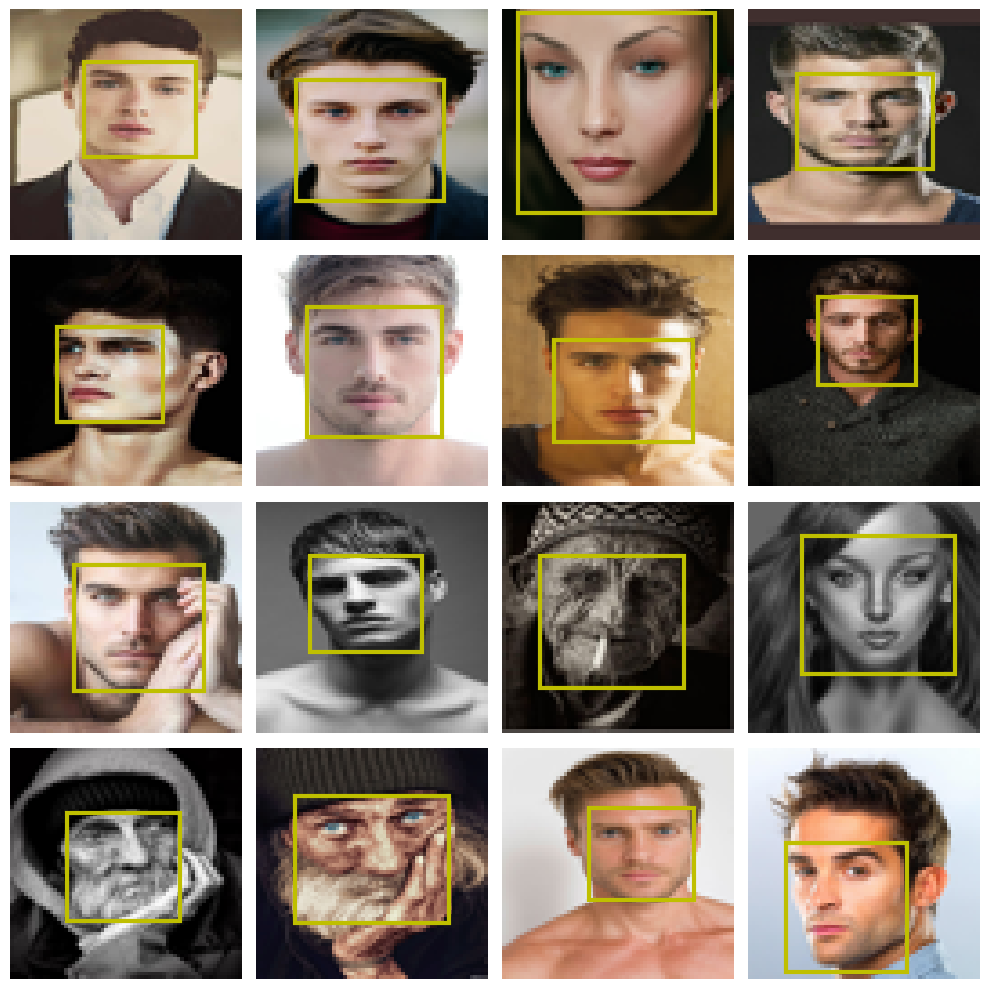

In [136]:
fig, axs = plt.subplots(4, 4)

idxs = torch.randperm(200)[:16]
imgs_list = imgs[idxs]

with torch.no_grad():
    preds = best_model(imgs_list)

p = 0

for i in range(4):
    for j in range(4):
        ax = axs[i][j]
        ax.imshow(imgs_list[p].permute((1,2,0)).numpy())
        rect = patches.Rectangle((preds[p][0],preds[p][1]), preds[p][2] - preds[p][0], preds[p][3] - preds[p][1], linewidth=3, edgecolor='y', facecolor='none')
        ax.add_patch(rect)
        ax.set_axis_off()
        p += 1

fig.set_size_inches(10, 10)
fig.tight_layout()

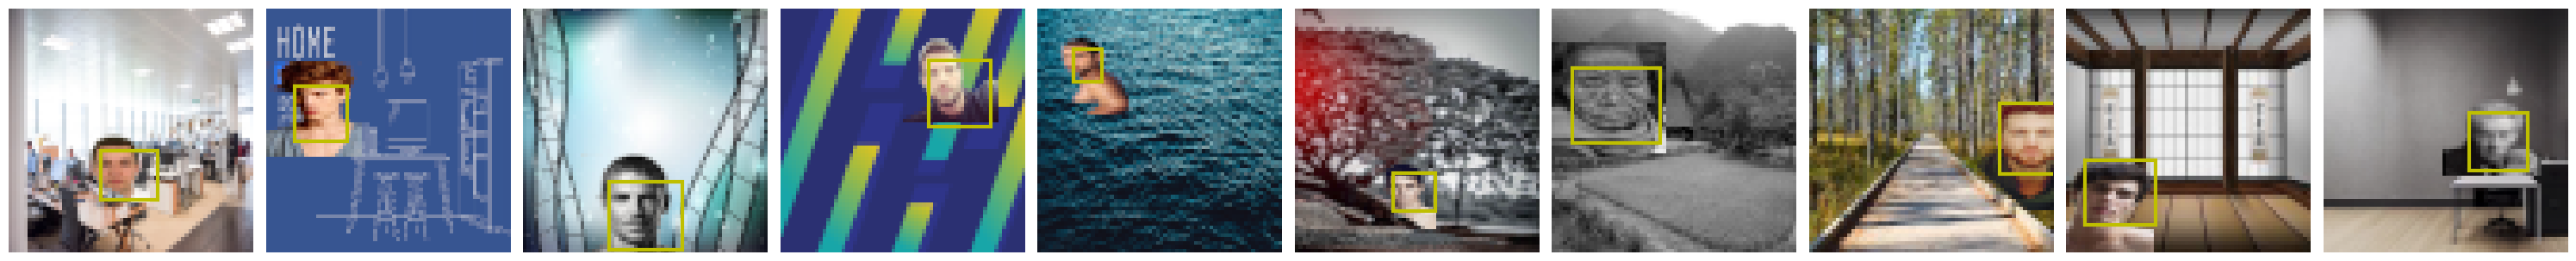

In [94]:
fig, axs = plt.subplots(1, 10)

imgs_list = imgs[-20:-10]
with torch.no_grad():
    preds = best_model(imgs_list)

for i in range(10):
    ax = axs[i]
    ax.imshow(imgs_list[i].permute((1,2,0)).numpy())
    rect = patches.Rectangle((preds[i][0],preds[i][1]), preds[i][2] - preds[i][0], preds[i][3] - preds[i][1], linewidth=3, edgecolor='y', facecolor='none')
    ax.add_patch(rect)
    ax.set_axis_off()

fig.set_size_inches(30, 20)
fig.tight_layout()

In [140]:
explainer = shap.GradientExplainer(best_model, imgs)
shap_values = explainer.shap_values(imgs_list[6:12])

In [141]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(imgs_list[6:12].numpy(), 1, -1), 1, 2)

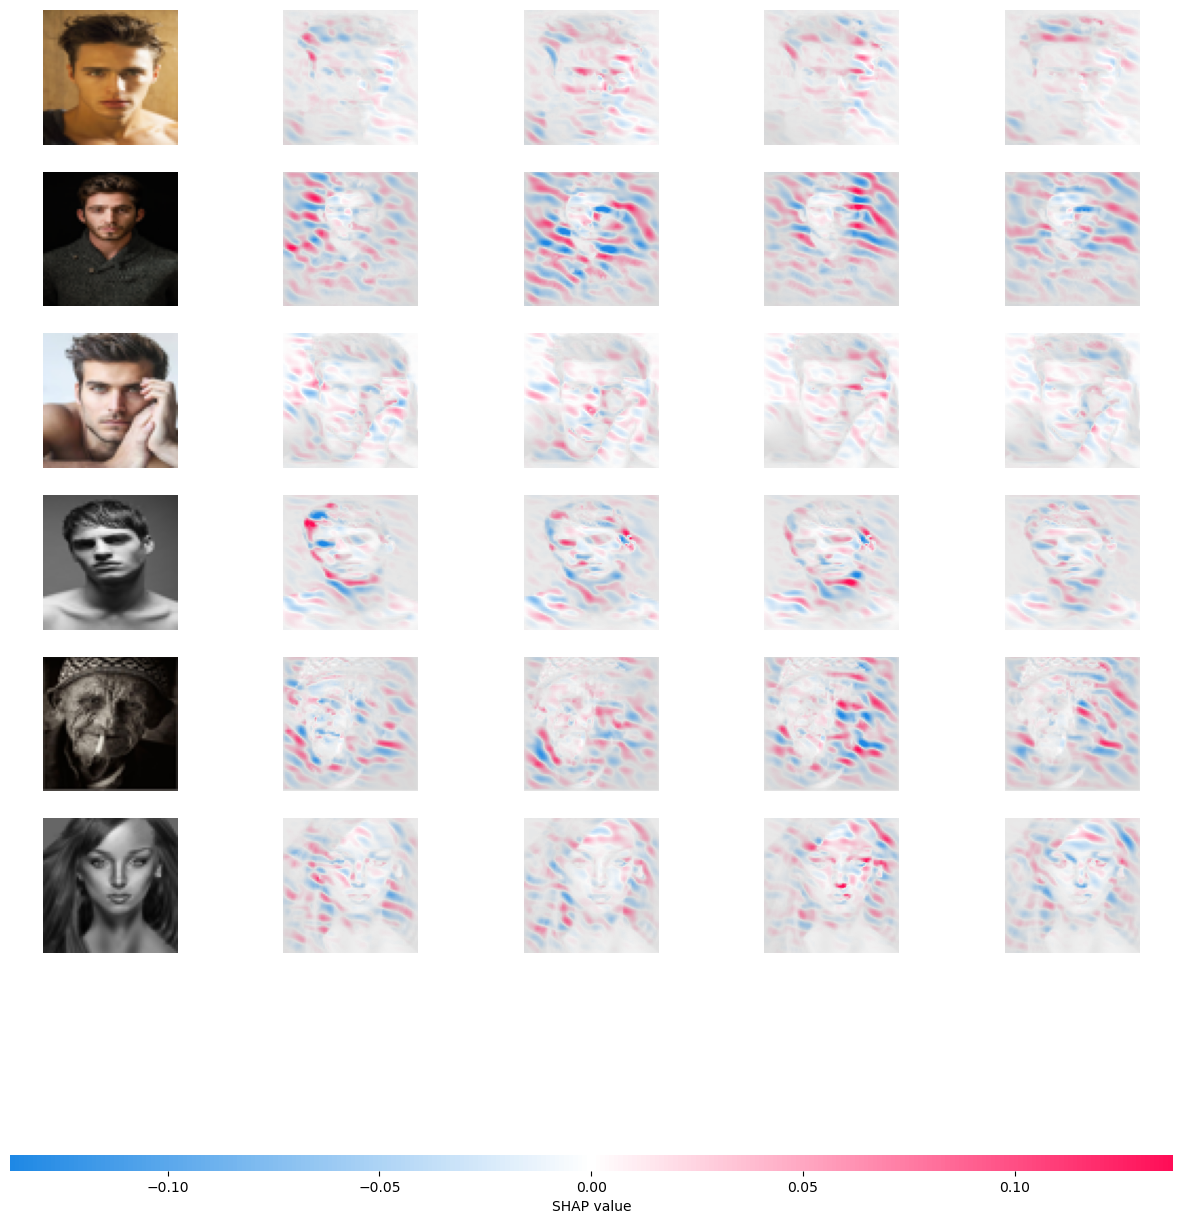

In [142]:
shap.image_plot(shap_numpy, test_numpy)